In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def load_data():
    dfa = pd.read_csv("../data/input/event.csv")

    dfb = pd.read_csv("../data/input/allegation.csv")

    dfb = dfb[["allegation_uid", "supervisor_uid", "tracking_id", "assigned_department", "assigned_division", "investigator_uid"]]

    df = pd.merge(dfa, dfb, on="allegation_uid", how="outer")
    return df



events = load_data()


/var/folders/4r/jhc99db14v58mjmncgtry0kc0000gn/T/ipykernel_66282/2253701421.py:2: DtypeWarning: Columns (5,12,13,14,28,31,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  dfa = pd.read_csv("../data/input/event.csv")
/var/folders/4r/jhc99db14v58mjmncgtry0kc0000gn/T/ipykernel_66282/2253701421.py:4: DtypeWarning: Columns (18,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dfb = pd.read_csv("../data/input/allegation.csv")


In [3]:
events.columns

Index(['event_uid', 'kind', 'year', 'month', 'day', 'time', 'raw_date', 'uid',
       'allegation_uid', 'appeal_uid', 'uof_uid', 'agency', 'badge_no',
       'employee_id', 'department_code', 'department_desc', 'division_desc',
       'unit_desc', 'unit_sub_desc', 'employee_class', 'rank_code',
       'rank_desc', 'employment_status', 'sworn', 'officer_inactive', 'salary',
       'overtime_annual_total', 'overtime_location', 'overtime_freq',
       'salary_freq', 'award', 'award_comments', 'left_reason',
       'left_reason_desc', 'years_of_service', 'source_agency', 'brady_uid',
       'supervisor_uid', 'tracking_id', 'assigned_department',
       'assigned_division', 'investigator_uid'],
      dtype='object')

In [4]:
events.kind.unique()

array(['investigation_complete', 'complaint_receive',
       'investigation_start', 'complaint_incident', 'officer_left',
       'suspension_start', nan, 'officer_post_decertification',
       'suspension_end', 'initial_action', 'board_hearing',
       'appeal_disposition', 'officer_hire',
       'officer_pc_12_qualification', 'officer_pay_prog_start',
       'officer_pay_effective', 'officer_level_1_cert', 'uof_occur',
       'check_date', 'appeal_hearing', 'award_recommended',
       'officer_rank', 'officer_overtime', 'appeal_file', 'claim_receive',
       'officer_dept', 'appeal_receive', 'claim_made', 'award_receive',
       'brady_list', 'claim_occur', 'claim_closed'], dtype=object)

In [5]:
def load_index():
    df = pd.read_csv("../../preprocess/data/output/clean.csv")
    return df 

wrongful_conviction_index = load_index()

event_table = events.copy()

wrongful_conviction_merge = pd.merge(wrongful_conviction_index, event_table, on="uid")

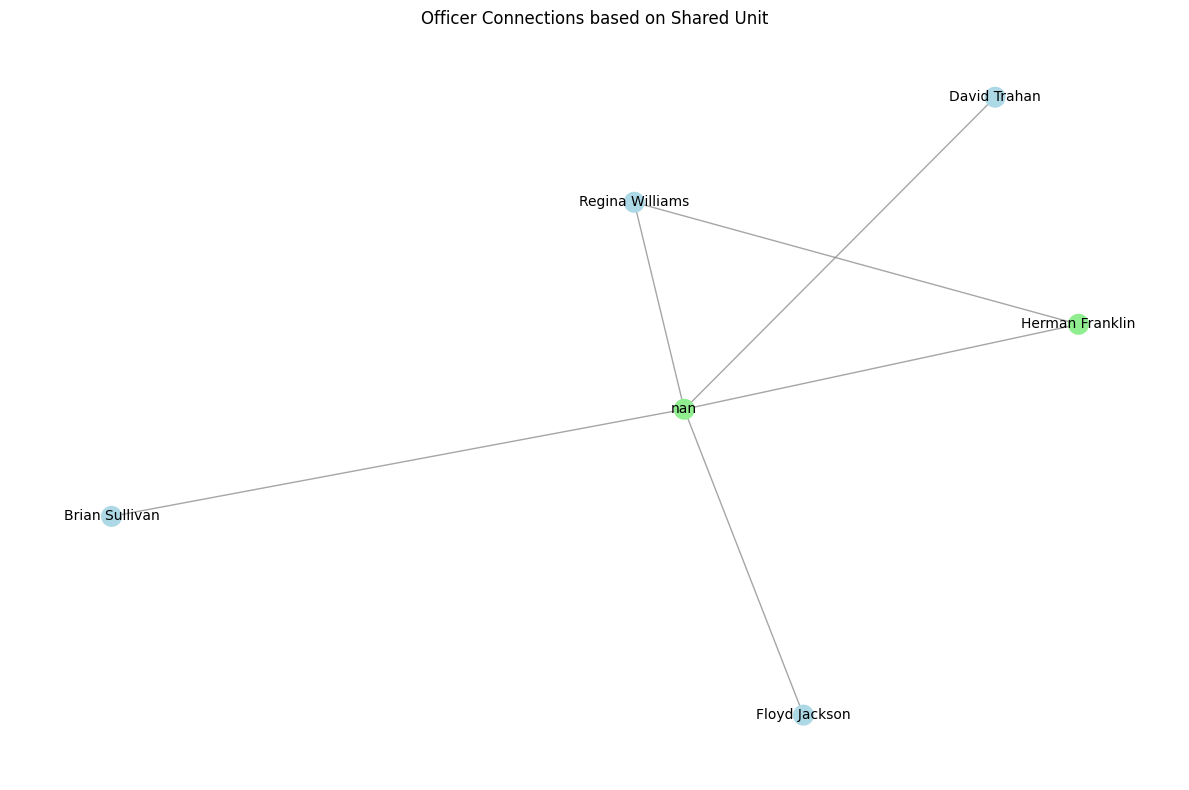

In [6]:
merged_table = pd.merge(event_table, wrongful_conviction_index, on='uid', how='left')

connections = {}

for _, row in wrongful_conviction_merge.iterrows():
    officer_name = row['officer_name']
    unit_desc = row['unit_desc']
    
    # Find all unique officers from the event table who share the same unit
    related_officers = merged_table[(merged_table['unit_desc'] == unit_desc) & (merged_table['officer_name'] != officer_name)]['officer_name'].unique()
    
    if len(related_officers) > 0:
        connections[officer_name] = {'related_officers': related_officers, 'unit': unit_desc}

G = nx.Graph()

for officer, data in connections.items():
    G.add_node(officer, type='Wrongful Conviction Officer')
    for related_officer in data['related_officers']:
        G.add_node(related_officer, type='Related Officer')
        G.add_edge(officer, related_officer, unit=data['unit'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
node_colors = ['lightblue' if G.nodes[node]['type'] == 'Wrongful Conviction Officer' else 'lightgreen' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7)
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.axis('off')
plt.title('Officer Connections based on Shared Unit')
plt.tight_layout()
plt.show()

output_table = pd.DataFrame(columns=['Wrongful Conviction Officer', 'Related Officer', 'Shared Unit'])

for officer, data in connections.items():
    for related_officer in data['related_officers']:
        new_row = pd.DataFrame({
            'Wrongful Conviction Officer': [officer],
            'Related Officer': [related_officer],
            'Shared Unit': [data['unit']]
        })
        output_table = pd.concat([output_table, new_row], ignore_index=True)

output_table.to_csv('officer_unit_connections.csv', index=False)